In [1]:
import lasio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prov import identifier


import view_well_file
import interpolation

In [22]:
import importlib
importlib.reload(view_well_file)


<module 'view_well_file' from 'Z:\\Prog\\HACKATHON\\view_well_file.py'>

In [3]:
DATA_DIR = "..\\data\\las"
EXCEL_DIR = "..\\data"

In [4]:
well_idx = []

In [5]:
for filename in os.listdir(DATA_DIR):
    # Print each filename
    well_idx.append(filename.split("_")[0])
    # print(filename)

In [6]:
well_idx = set(well_idx)

In [7]:
len(well_idx)

41

In [8]:
type(list(well_idx)[0])

str

In [9]:
excel = pd.read_excel(EXCEL_DIR + "\\Отбивки пласта АС11-2.xlsx")

In [10]:
upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [11]:
lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

In [12]:
target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]


In [13]:
target_layers

,Well identifier,upper,lower
1,12,-2161.95,-2183.98
2,13,-2158.72,-2175.36
3,14,-2170.38,-2190.59
4,15,-2170.84,-2188.69
5,16,-2157.70,-2178.94
6,17,-2150.80,-2171.09
7,18,-2146.87,-2167.39
8,19,-2129.24,-2150.87
9,20,-2141.56,-2162.04
10,22,-2129.92,-2146.85


In [14]:
target_layers.iloc[30]

Well identifier         44
upper             -2128.99
lower             -2145.62
Name: 32, dtype: object

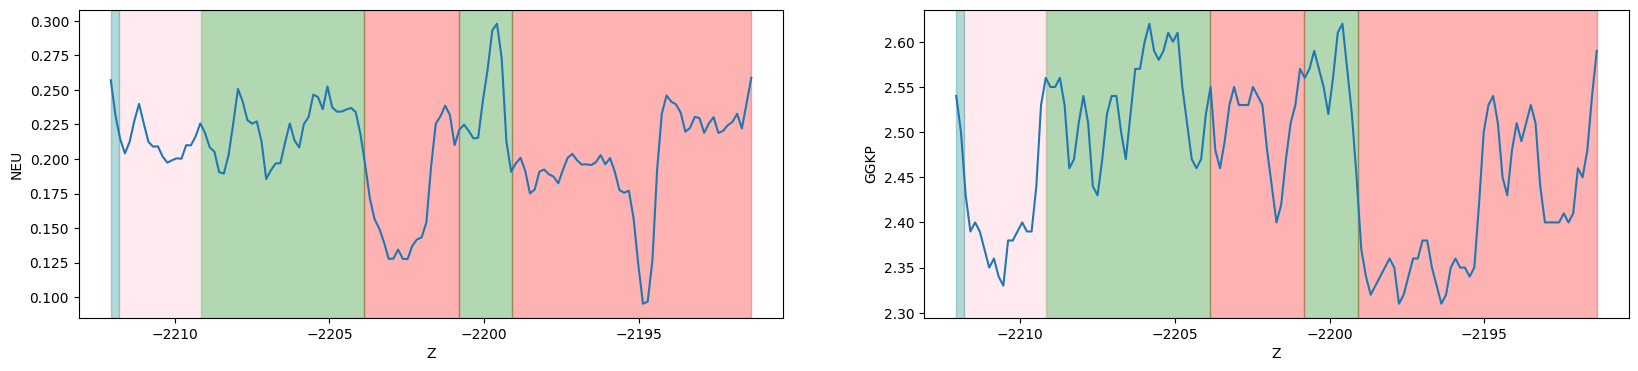

In [24]:
z, ggkp, neu = view_well_file.view_well(20, target_layers)

In [27]:
z.shape

(137,)

In [33]:
z_interp, ggkp_interp = interpolation.interpolate(z, ggkp, 200)

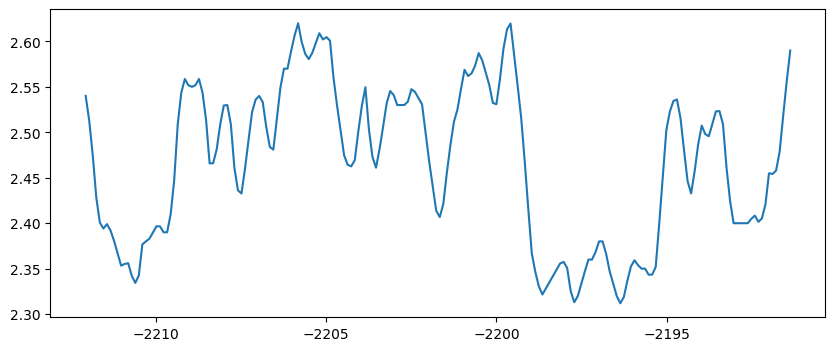

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(z_interp, ggkp_interp)
plt.show()

189.1076115485545


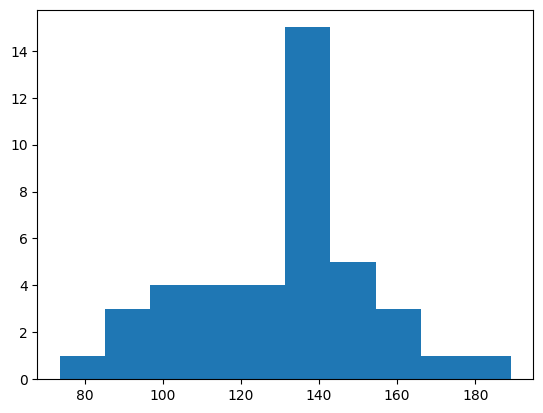

In [29]:
plt.hist((target_layers.upper - target_layers.lower) / 0.1524)
print(max((target_layers.upper - target_layers.lower) / 0.1524))
plt.show()

In [48]:
data_ = []

for well_index in range(len(well_idx)):
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpolation.interpolate(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], 200)
    data_.append(data_interp[1])

data = np.empty(len(data_), dtype=object)
for i, sublist in enumerate(data_):
    data[i] = np.array(sublist)

data = np.vstack(data)

In [49]:
data

array([[2.57      , 2.56022236, 2.54088943, ..., 2.50831155, 2.46016884,
        2.47      ],
       [2.5       , 2.50587245, 2.51872446, ..., 2.57177607, 2.56588803,
        2.56      ],
       [2.48      , 2.48658346, 2.49633383, ..., 2.46      , 2.46341746,
        2.47      ],
       ...,
       [2.27      , 2.40386798, 2.50849064, ..., 2.41537652, 2.45306479,
        2.52      ],
       [2.57      , 2.56341707, 2.54100482, ..., 2.5063316 , 2.5       ,
        2.5       ],
       [2.58      , 2.58      , 2.58      , ..., 2.55602036, 2.55096946,
        2.53      ]])

In [85]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# Implementing DBSCAN with Mahalanobis distance

# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=1.1, min_samples=2)
dbscan.fit(data)

# Get cluster labels
labels = dbscan.labels_

# Print the cluster labels
print("Cluster labels:", labels)

Cluster labels: [ 0  1  2  1  0  2  2  1 -1 -1  3 -1 -1  2 -1 -1 -1 -1  3 -1 -1 -1 -1 -1
 -1  2  4  2 -1  2  4  2 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [56]:
scaled_data

array([[ 0.72848265,  0.59155977,  0.24172228, ...,  0.4364279 ,
        -0.22464799, -0.34064129],
       [-0.31688995, -0.31339849, -0.08557784, ...,  1.08173996,
         0.97613661,  0.90387987],
       [-0.61556784, -0.63457158, -0.41621016, ..., -0.05480766,
        -0.18774943, -0.34064129],
       ...,
       [-3.75168566, -2.01183333, -0.23669602, ..., -0.50854259,
        -0.30533765,  0.35075935],
       [ 0.72848265,  0.64475359,  0.24342626, ...,  0.41629559,
         0.22776408,  0.07419909],
       [ 0.8778216 ,  0.92086925,  0.81925042, ...,  0.92153474,
         0.80668774,  0.48903948]])

30


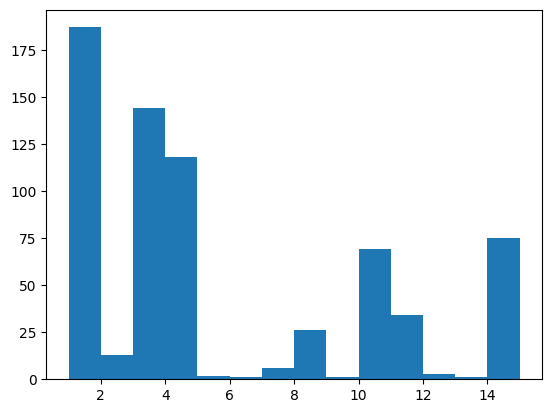

In [37]:
faceis = []

for well_index in range(len(well_idx)):
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    las_dis = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_discrete.las"))
    target_layer_idx_dis = np.where((las_dis['Z'] < target_layers.iloc[well_index].upper) & (las_dis['Z'] > target_layers.iloc[well_index].lower))
    try:
        faceis.extend(las_dis['FACIES'][np.insert(target_layer_idx_dis, 0, target_layer_idx_dis[0][0]-1)])
    except IndexError:
        print(well_index)
        
faceis = np.array(faceis)
faceis = faceis[~np.isnan(faceis)]

plt.hist(faceis, bins='doane')
plt.show()

мысль - свёртки

depth - длина по стволу - по кривой
sstvd - абсолютная переведённая
z - от моря
одна положительная другая отрицательная разницы нет
лучше либо 2 либо 3

ggkp - гамма каротаж - фоновое гамма излучение

отбивки - границы пласта(субгоризонтальная бурная порода) - точка входа и выхода из целевого пласта - остальное неинтересно
Z - тот же столбик
MD - глубина

дискретные файлы
facies - ручная разметка вручную
log9 - обонзачает то же самое, просто укрупленная, достаточно одной
когда пересекаем глубину начинается код N


neu - нейтронный каротаж - неважно? можно по одной, но с этой +



суть задачи

- кластеризация всех скважин в пределах пластов по форме гамма и второго каротажа
- дальше сложнее: кластеризация кусков формы внутри пласта. То есть каждый график разбить на кусочки - берутся из дискретности. Не
- - Не всегда размечены именно формы, какой-то информации у нас может не быть
- - Цель - не 100% совпадение с разметкой ручной
- - Скользящее окно не дало плодов, проблемы - шум, интересуют крупные, на каждую скважину не более 3

отобразить, посмотреть, обрезать по пласту, поискать основные формы, описаны в какой-тио методике - простейшие геометрические - коробки, пирамиды, воронки
по второй - сложно непонятно